<a href="https://colab.research.google.com/github/yeankyoung/Lab2/blob/main/Lab2_Yeankyoung_Hahm_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
* [Network-based Spatial Information Theory Index](#Network-based-Spatial-Information-Theory-Index)
	* [*from scratch*](#*from-scratch*)


# Network-based Spatial Information Theory Index 

## *from scratch*

What if you want to calculate the best segregation measure starting with no data?  
We've got you covered

*This notebook uses functionality found in the [`cenpy.products`](https://nbviewer.jupyter.org/gist/ljwolf/3481aeadf1b0fbb46b72553a08bfc4e6?flush_cache=true) module, which will be released officially in July. If you want to replicate this notebook prior to `cenpy`'s 1.0 release, you can install the development version of  with `pip install git+https://github.com/ljwolf/cenpy.git@product`*

*Further, the notebook leverages a function from [contextily](https://github.com/darribas/contextily) that has not yet been released. Similar to above, you can use the most recent github version of the library to replicated the functionality in this notebook with `pip install git+https://github.com/darribas/contextily.git`*


##add pip packages

In [1]:
!pip install rtree pygeos geopandas segregation contextily cenpy urbanaccess pandana

     |████████████████████████████████| 1.0 MB 17.1 MB/s 
     |████████████████████████████████| 2.1 MB 32.7 MB/s 
     |████████████████████████████████| 1.0 MB 33.3 MB/s 
     |████████████████████████████████| 164 kB 40.9 MB/s 
     |████████████████████████████████| 48 kB 2.4 MB/s 
     |████████████████████████████████| 1.7 MB 38.2 MB/s 
     |████████████████████████████████| 6.3 MB 14.7 MB/s 
     |████████████████████████████████| 16.7 MB 264 kB/s 
     |████████████████████████████████| 183 kB 35.6 MB/s 
     |████████████████████████████████| 2.4 MB 35.7 MB/s 
     |████████████████████████████████| 78 kB 3.9 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 4.3 MB 56.7 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 132 kB 64.9 MB/s 
     |████████████████████████████████| 8.6 MB 51.4 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |██████████████

In [2]:
!pip install git+https://github.com/darribas/contextily.git

  Cloning https://github.com/darribas/contextily.git to /tmp/pip-req-build-ruowt6gx
  Running command git clone -q https://github.com/darribas/contextily.git /tmp/pip-req-build-ruowt6gx
  Created wheel for contextily: filename=contextily-1.0.0-py3-none-any.whl size=23526 sha256=411e4fdae54e8e150304247bbf0e8be7cbde4f9e11d40d111b46c654cf9513b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-clw0g_qv/wheels/1f/20/a8/b854c09f0832bf09eed70b9da665ee0ffebf7621726c25efed
Successfully built contextily
  Attempting uninstall: contextily
    Found existing installation: contextily 1.2.0
    Uninstalling contextily-1.2.0:
      Successfully uninstalled contextily-1.2.0


In [3]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import segregation
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import cenpy

sns.set_context('notebook')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
cenpy.set_sitekey('394eacb41bdf446dbfe35287bb1b4cb87d75d505', overwrite=True) # note you should replace this key with your own from here: https://api.census.gov/data/key_signup.html

'/usr/local/lib/python3.7/dist-packages/cenpy/SITEKEY.txt'

<br>
First, we need to collect some data from the Census API. Using `cenpy`, we can grab all the necessary data in a single call. Let's store the variables we need in a list (these are total population counts from the 2017 ACS. See the [census api docs](https://api.census.gov/data/2017/acs/acs5/variables.html) for more details)  

<br>
    

In [5]:
black = 'B03002_004E'
white = 'B03002_003E'
hispanic = 'B03002_012E'
asian = 'B03002_006E'
variables = [white, black, hispanic, asian]

<br>
Using Atlanta as a test case, we'll grab the data for the four different race categories and plot the non-hispanic Black population

In [6]:
atl = cenpy.products.ACS(2017).from_msa(msa='Atlanta, GA', variables=variables.copy(), level='tract')

In [7]:
atl.head()

,GEOID,geometry,B03002_003E,B03002_004E,B03002_006E,B03002_012E,NAME,state,county,tract
0,13045911200,"POLYGON ((-9497260.090 3966886.990, -9497199.2...",4631.0,1014.0,9.0,7.0,"Census Tract 9112, Carroll County, Georgia",13,045,911200
1,13045910900,"POLYGON ((-9484220.910 3955731.220, -9484201.0...",3785.0,135.0,0.0,101.0,"Census Tract 9109, Carroll County, Georgia",13,045,910900
2,13045910702,"POLYGON ((-9459721.600 3972807.310, -9459709.8...",6457.0,903.0,88.0,189.0,"Census Tract 9107.02, Carroll County, Georgia",13,045,910702
3,13097080201,"POLYGON ((-9431448.010 4002804.990, -9431445.9...",2803.0,1497.0,0.0,1192.0,"Census Tract 802.01, Douglas County, Georgia",13,097,080201
4,13067031506,"POLYGON ((-9426138.410 4012435.900, -9426134.7...",2069.0,1959.0,155.0,432.0,"Census Tract 315.06, Cobb County, Georgia",13,067,031506


(-9516976.031000001, -9257699.189, 3862831.7115, 4123947.9185000006)

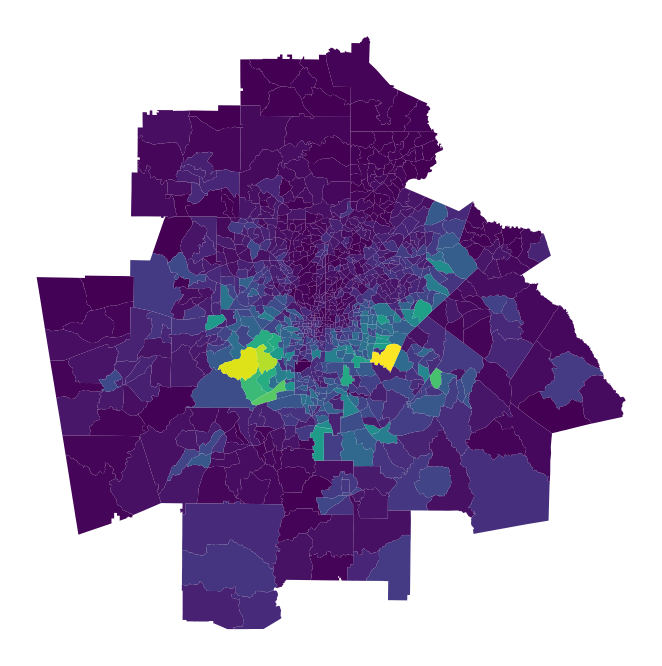

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
atl.plot(column='B03002_004E', ax=ax)
ax.axis('off')

In [9]:
atl = atl.to_crs({'init': 'epsg:4326'})

<br>
Now, we'll grab a walkable street network from OSM and use it to calculate our distance-decayed population sums. Under the hood we're using `pandana` and `urbanaccess` from the wonderful [UDST](http://www.urbansim.com/udst)

In [10]:
atl_network = segregation.network.get_osm_network(atl)

Building network


downloading the network takes awhile, so uncomment to save it and you can load later

In [11]:
atl_network.save_hdf5('atl_network.h5')

and use this to read it back in

In [12]:
import pandana as pdna
atl_network = pdna.Network.from_hdf5('atl_network.h5')

In [13]:
# Note that the most recent version of pandana may have some issues with memory consumption that could lead to failure (https://github.com/UDST/pandana/issues/107)
# If your kernel crashes running this cell, try setting a smaller threshold distance like 1000

# this cell can also take 

atl_access = segregation.network.calc_access(atl, network=atl_network, distance=1000, decay='exp', variables=variables)

In [14]:
atl_access.head()

,acc_B03002_003E,acc_B03002_004E,acc_B03002_012E,acc_B03002_006E
id,,,,
52373896,0.0,0.0,0.0,0.0
52373906,0.0,0.0,0.0,0.0
52373995,0.0,0.0,0.0,0.0
52374024,0.0,0.0,0.0,0.0
52374089,0.0,0.0,0.0,0.0


<br>
Inside the accessibility calculation, pandana is snapping each tract centroid to its nearest intersection on the walk network. Then, it calculates the shortest path distance between every pair of intersrctions in the network and sums up the total population for each group accessible within the specified threshold, while applying a distance decay function to discount further distances

<br>
That means population access is measured for *each intersection* in the network. In essence, we're modeling down from the tract level to the intersection level. We can quickly convert the network intersections to a geopandas GeoDataFrame to plot and compare with the original tracts

In [15]:
net_points =gpd.GeoDataFrame(atl_access, geometry=gpd.points_from_xy(atl_network.nodes_df['x'],atl_network.nodes_df['y']))

In [16]:
net_points.crs = {'init': 'epsg:4326'}

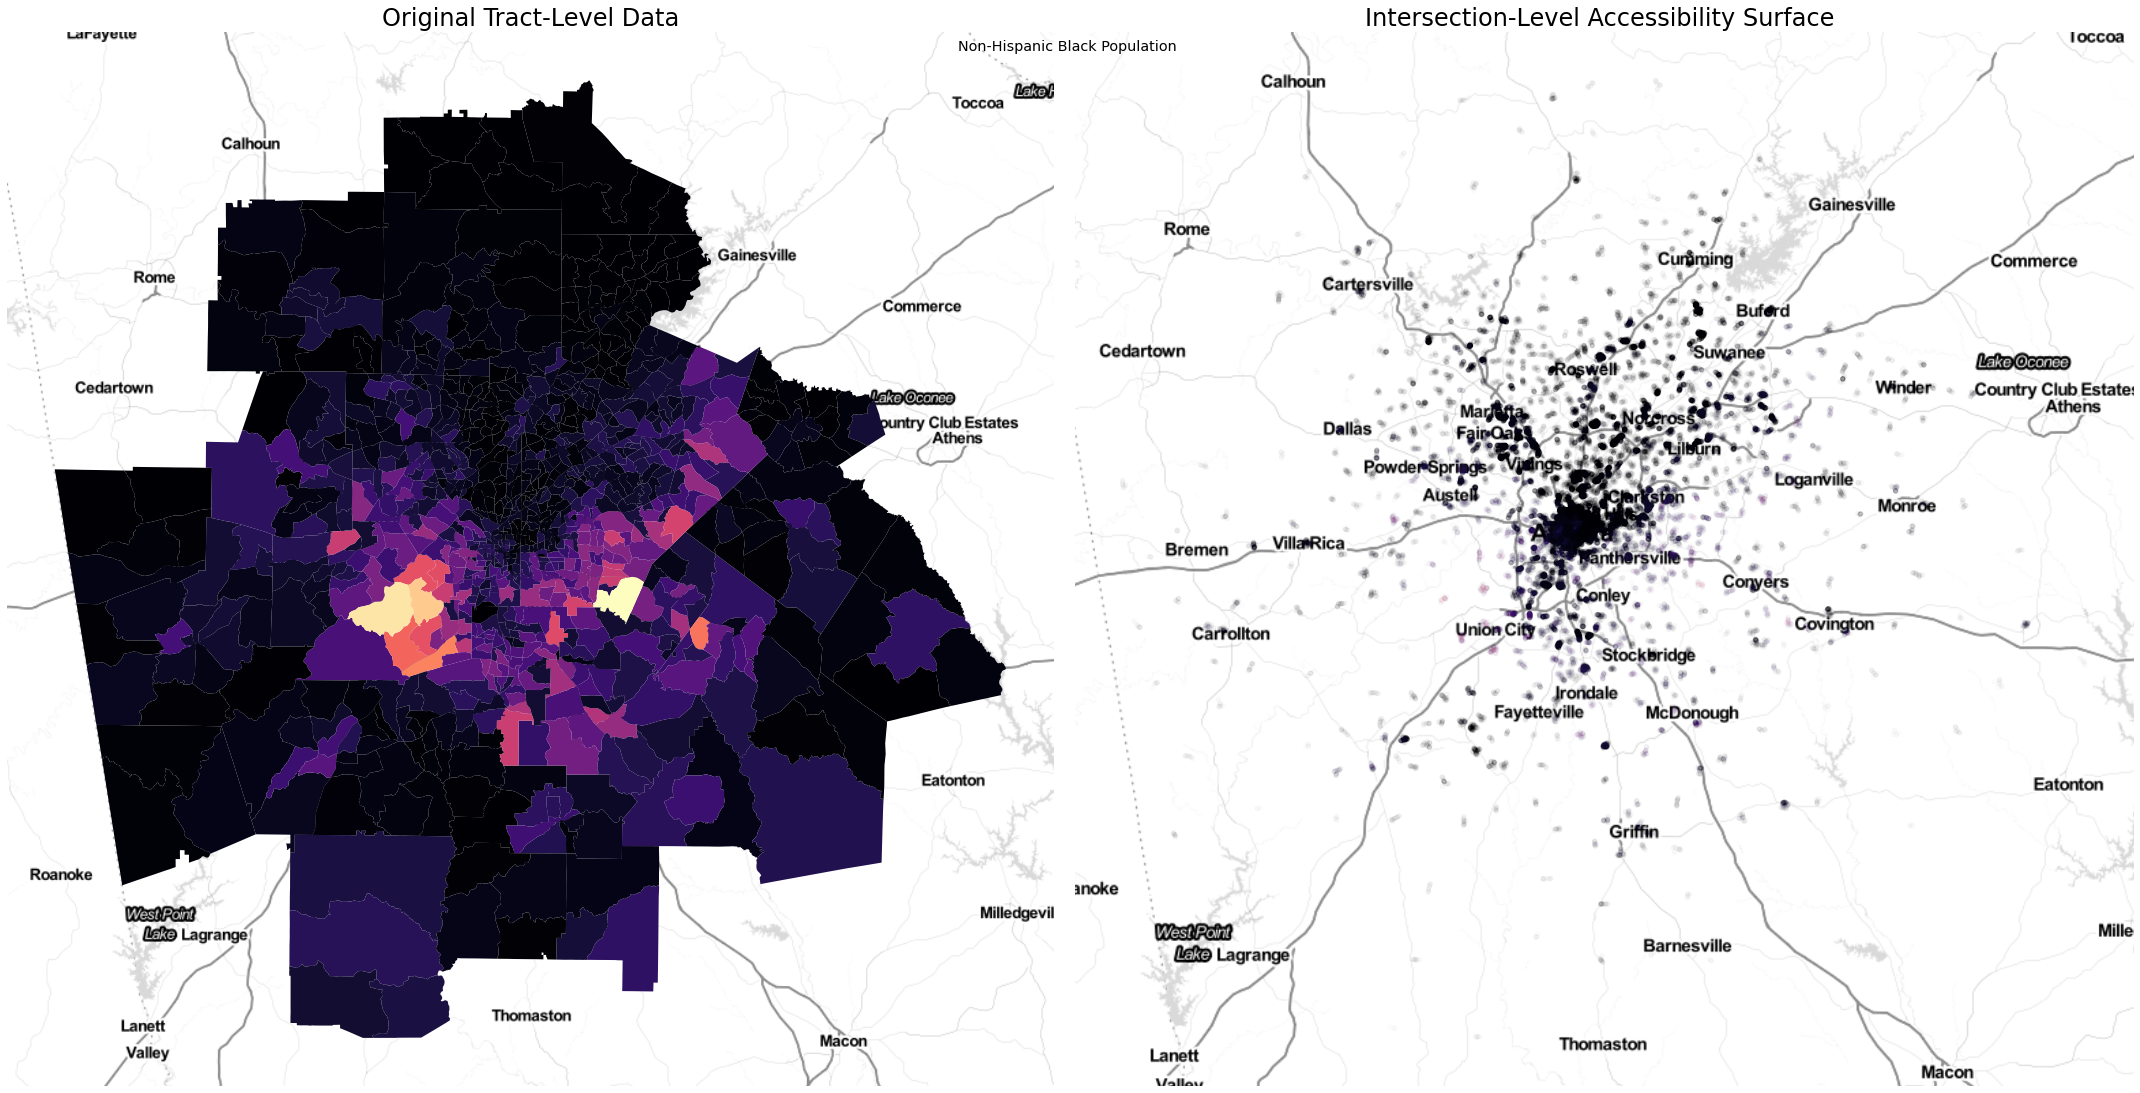

In [17]:
fig, ax = plt.subplots(1,2,figsize=(30,15))


# tracts
atl.to_crs({'init': 'epsg:3857'}).plot('B03002_004E', ax=ax[0], cmap='magma')
ctx.add_basemap(ax[0],url=ctx.sources.ST_TONER_LITE)
ax[0].axis('off')
ax[0].set_title('Original Tract-Level Data',fontsize=24)

# network
net_points[net_points.acc_B03002_004E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_004E', alpha=0.01, ax=ax[1], cmap='magma', s=20)
ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[1].axis('off')
ax[1].set_title('Intersection-Level Accessibility Surface ', fontsize=24)

plt.suptitle('Non-Hispanic Black Population')
plt.tight_layout()



The main advantage of the plot on the right
is that we avoid the visual distortion created by the large but sparsely populated tracts on the periphery and between the highways. It's a much better representation of metropolitan Atlanta's spatial structure. We use this version to compute the spatial information theory index.<br>   

  
Apart from the fact that we're now constraining the visualization to only the developed land, using transparency gives a further sense of the metro's development intensity, since denser areas appear more saturated. The hues have shifted in space slightly (e.g. the the brightest locus has shifted from the southwest in the left map toward the center in the right map) since they now represent distance-weighted densities, rather than totals.

Text(0.5, 1.0, 'Asian Accessibility Surface ')

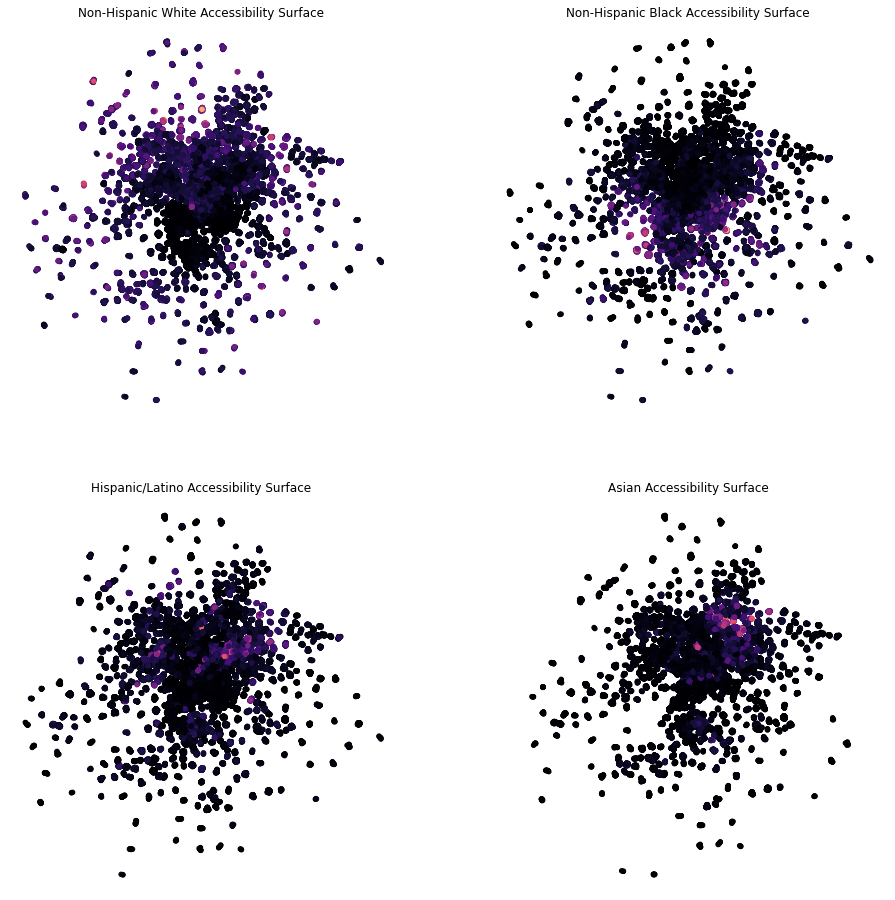

In [18]:
fig, ax = plt.subplots(2,2, figsize=(16,16))
ax = ax.flatten()


net_points[net_points.acc_B03002_003E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_003E', ax=ax[0], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[0].axis('off')
ax[0].set_title('Non-Hispanic White Accessibility Surface ')

net_points[net_points.acc_B03002_004E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_004E', ax=ax[1], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[1].axis('off')
ax[1].set_title('Non-Hispanic Black Accessibility Surface ')

net_points[net_points.acc_B03002_012E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_012E', ax=ax[2], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[2].axis('off')
ax[2].set_title('Hispanic/Latino Accessibility Surface ')

net_points[net_points.acc_B03002_006E > 0].to_crs({'init': 'epsg:3857'}).plot('acc_B03002_006E', ax=ax[3], cmap='magma', s=20)
#ctx.add_basemap(ax[1],url=ctx.sources.ST_TONER_LITE )
ax[3].axis('off')
ax[3].set_title('Asian Accessibility Surface ')

Now we can use these surfaces to calculate the multi-group network-based spatial information theory index

In [19]:
from segregation.aspatial import Multi_Information_Theory

In [20]:
accvars = ['acc_'+variable for variable in variables]

In [21]:
# spatial information theory using the network kernel

Multi_Information_Theory(atl_access, accvars).statistic

0.24572549210584008

We can compare this statistic with what we would obtain if we didn't consider spatial effects (i.e. if local context is only considered the census tract itself)

In [22]:
# aspatial information theory

Multi_Information_Theory(atl, variables).statistic

0.2856858192363313

In [24]:
print("Thank You")

Thank You
